<div style="text-align: center; margin: 20px; background: linear-gradient(to right, #ff007f, #ff66b2); border-radius: 10px; padding: 30px;">
  <h1 style="color: white; font-family: 'Arial', sans-serif; font-size: 3em; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);">
    CS495 Notebook: Final Capstone – Anime Synopsis Generation
  </h1>
  <h2 style="color: #fff0f5; font-family: 'Arial', sans-serif; font-size: 2em; font-style: italic;">
    A Comparative Evaluation of Text Generation Models
  </h2>
  
  <hr style="border: 2px solid #ffffff; margin: 20px auto; width: 70%; border-radius: 5px;" />
  
  <p style="font-family: 'Arial', sans-serif; color: white; font-size: 1.2em;">
      <strong>Author:</strong> <span style="color: #ffccff;">Noëlla Buti</span><br />
      <strong>Term:</strong> <span style="color: #ffccff;">Spring 2025</span><br />
      <strong>Model Used:</strong> <span style="color: #ffccff;">T5-Small (Fine-Tuned)</span><br />
      <strong>Contact:</strong> <a href="mailto:noella.buti@bellevuecollege.edu" style="color: #ffccff; text-decoration: none;">noella.buti@bellevuecollege.edu</a><br />
  </p>
</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS 495 DataScience Capstone Project


In [2]:
# --- Install ---
!pip install transformers datasets sentence-transformers umap-learn evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00


In [4]:
# --- Imports ---
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import umap.umap_ as umap
from tqdm import tqdm
from datasets import Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    logging
)
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

os.environ["WANDB_DISABLED"] = "true"
logging.set_verbosity_info()

In [5]:
# --- Config ---
model_name = "t5-small"
max_input_len = 64
max_target_len = 150

In [6]:
# --- Load & Prepare Data ---
train_df = pd.read_csv("prompt_synopsis_train.csv")
test_df_full = pd.read_csv("prompt_synopsis_test.csv")

train_df = train_df[["prompt", "synopsis"]].dropna().reset_index(drop=True)
test_df_full = test_df_full[["prompt", "synopsis"]].dropna().reset_index(drop=True)
train_df["input_text"] = "generate synopsis: " + train_df["prompt"]
train_df["target_text"] = train_df["synopsis"]
test_df_full["input_text"] = "generate synopsis: " + test_df_full["prompt"]
test_df_full["target_text"] = test_df_full["synopsis"]

train_dataset = Dataset.from_pandas(train_df[["input_text", "target_text"]])
test_dataset = Dataset.from_pandas(test_df_full[["input_text", "target_text"]])

In [7]:
# --- Tokenization ---
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def tokenize(batch):
    inputs = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=max_input_len)
    targets = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=max_target_len)
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/tokenizer.json
loading file chat_template.jinja from cache at None
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reaso

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
     

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/model.safetensors
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/generation_config.json
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}



Map:   0%|          | 0/60260 [00:00<?, ? examples/s]

Map:   0%|          | 0/10620 [00:00<?, ? examples/s]

In [11]:
# --- Training ---
training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/CS 495 DataScience Capstone Project/t5_anime_model",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="/content/drive/My Drive/CS 495 DataScience Capstone Project/logs",
    logging_steps=100,
    report_to="none"
)

training_args.generation_max_length = 150
training_args.generation_num_beams = 4
training_args.predict_with_generate = True
training_args.generation_config = None

PyTorch: setting up devices


In [12]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

train_output = trainer.train()
print(train_output)

/tmp/ipython-input-12-63289149.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The following columns in the Training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input_text, target_text. If input_text, target_text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 60,260
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 9,420
  Number of trainable parameters = 60,506,624
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_

Epoch,Training Loss,Validation Loss
1,2.889100,2.681830
2,2.808000,2.623364
3,2.742500,2.592033
4,2.739700,2.570870
5,2.697400,2.556279
6,2.671200,2.545763
7,2.646800,2.538926
8,2.626400,2.534079
9,2.658300,2.531205
10,2.603000,2.530646


The following columns in the Evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input_text, target_text. If input_text, target_text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 10620
  Batch size = 64
Saving model checkpoint to /content/drive/My Drive/CS 495 DataScience Capstone Project/t5_anime_model/checkpoint-942
Configuration saved in /content/drive/My Drive/CS 495 DataScience Capstone Project/t5_anime_model/checkpoint-942/config.json
Configuration saved in /content/drive/My Drive/CS 495 DataScience Capstone Project/t5_anime_model/checkpoint-942/generation_config.json
Model weights saved in /content/drive/My Drive/CS 495 DataScience Capstone Project/t5_anime_model/checkpoint-942/model.safetensors
tokenizer config file saved in /content/drive/My Drive/CS 495 DataScience Capstone Project/t5_anime_model/checkpoint-942/tokeniz

TrainOutput(global_step=9420, training_loss=2.733043760959763, metrics={'train_runtime': 2415.2667, 'train_samples_per_second': 249.496, 'train_steps_per_second': 3.9, 'total_flos': 1.01946211958784e+16, 'train_loss': 2.733043760959763, 'epoch': 10.0})


In [13]:
# --- Training Loss Plot ---
def plot_loss(trainer):
    logs = trainer.state.log_history
    train_loss = [x["loss"] for x in logs if "loss" in x and "epoch" in x]
    eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x and "epoch" in x]
    epochs_train = range(1, len(train_loss) + 1)
    epochs_eval = range(1, len(eval_loss) + 1)

    plt.figure(figsize=(8, 5))
    if train_loss:
        plt.plot(epochs_train, train_loss, label="Train Loss")
    if eval_loss:
        plt.plot(epochs_eval, eval_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

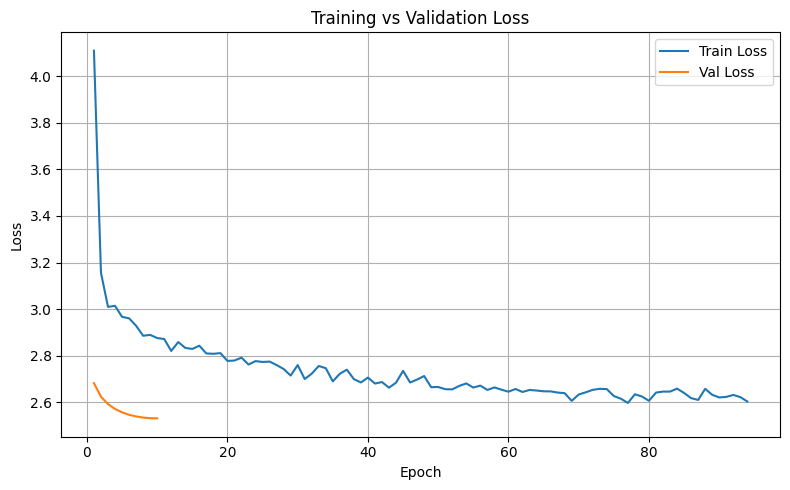

In [14]:
plot_loss(trainer)

In [15]:
# --- Load Test Set ---
testing_df = pd.read_csv("prompt_synopsis_test.csv")
testing_df = testing_df.iloc[[20, 26, 64, 84, 88, 98, 106, 111, 127, 164, 190, 199, 225, 231, 242, 244, 259, 298, 10597, 10609]].reset_index(drop=True)

input_prompts = testing_df["prompt"].tolist()
true_synopsis = testing_df["synopsis"].tolist()
tags = testing_df["tags_combined"].tolist()
prompts = ["generate synopsis: " + p for p in input_prompts]

In [16]:
# --- Perplexity Calculation ---
encodings = tokenizer(prompts, padding=True, truncation=True, max_length=max_input_len, return_tensors="pt")

with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(true_synopsis, padding=True, truncation=True, max_length=max_target_len, return_tensors="pt")

labels = target_encodings["input_ids"]
labels[labels == tokenizer.pad_token_id] = -100

input_ids = encodings["input_ids"].to(model.device)
attention_mask = encodings["attention_mask"].to(model.device)
labels = labels.to(model.device)
model.eval()

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss.item()
    perplexity = math.exp(loss)

print(f"\nT5 Test Loss: {loss:.4f}")
print(f"T5 Test Perplexity;;: {perplexity:.2f}")


T5 Test Loss: 3.7352
T5 Test Perplexity;;: 41.90


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [17]:
# --- Evaluation & Visualization ---
sbert = SentenceTransformer("all-MiniLM-L6-v2")
results = []

for i in range(len(prompts)):
    prompt = prompts[i]
    reference = true_synopsis[i]
    tag = tags[i]

    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=max_input_len).input_ids.to(model.device)

    with torch.no_grad():
        output = model.generate(input_ids, max_length=max_target_len, num_beams=4, early_stopping=True)
        generated = tokenizer.decode(output[0], skip_special_tokens=True)

    emb_tag = sbert.encode(tag)
    emb_gen = sbert.encode(generated)
    similarity = cosine_similarity([emb_tag], [emb_gen])[0][0]

    results.append({
        "tags_combined": tag,
        "prompt": input_prompts[i],
        "generated": generated,
        "true": reference,
        "cosine_similarity": similarity
    })

    if i < 20:
        print(f"\nPrompt {i+1}: {input_prompts[i]}")
        print(f"Generated: {generated}")
        print(f"True:      {reference}")
        print(f"Cosine Similarity: {similarity:.3f}")
        print("—" * 50)

df_results = pd.DataFrame(results)
df_results.to_csv("t5_small_results.csv", index=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/config.json
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/model.safetensors
All model checkpoint weights were used when initializing BertModel.

All the weights of BertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/tokenizer_config.json
loading file chat_template.jinja from cache at None


config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Prompt 1: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.
Generated: the story is about a young girl named sakura, who is a sakura. she is a sakura, a sakura, a sakura, a sakura, a sakura, a sakura, a sakura, a sakura, a sakura, and a sakura.
True:      on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut this time, he may be bitin

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


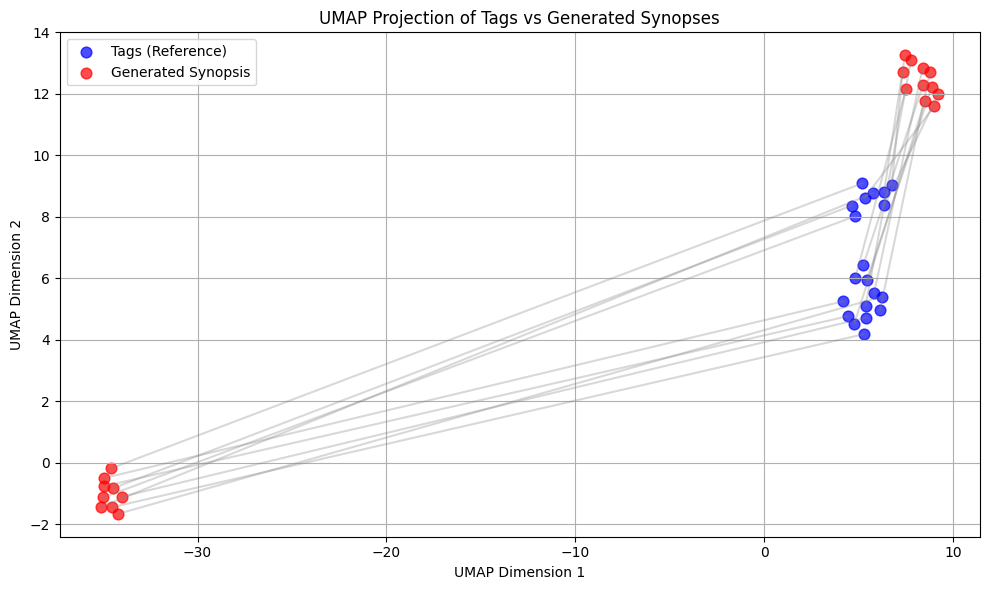

In [20]:
# --- UMAP Visualization ---
texts = tags + [r["generated"] for r in results]
embeddings = sbert.encode(texts)
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="cosine", random_state=42)
reduced = reducer.fit_transform(embeddings)
n = len(tags)
tags_2d = reduced[:n]
gen_2d = reduced[n:]

plt.figure(figsize=(10, 6))
plt.scatter(tags_2d[:, 0], tags_2d[:, 1], c='blue', label='Tags (Reference)', alpha=0.7, s=60)
plt.scatter(gen_2d[:, 0], gen_2d[:, 1], c='red', label='Generated Synopsis', alpha=0.7, s=60)

for i in range(n):
    plt.plot([tags_2d[i, 0], gen_2d[i, 0]], [tags_2d[i, 1], gen_2d[i, 1]], 'gray', alpha=0.3)

plt.title("UMAP Projection of Tags vs Generated Synopses")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()